<a href="https://colab.research.google.com/github/gsfreitas/engenharia-medica/blob/main/atividade_pratica_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seleção escalar de características

In [71]:
# importando as bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import itertools
import scipy.io
import scipy.fft as fft
from scipy.signal import welch
from sklearn import svm
from scipy.stats import shapiro
import seaborn as sns
import operator

In [72]:
# leitura e tratamento dos dados
data_1 = scipy.io.loadmat("/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-4/Dados_exercicio1.mat")
adiposo = data_1['figadoadiposo']
cirrotico = data_1['figadocirrotico']

**1)** Seleção escalar de características. Nesta tarefa vamos testar o procedimento de seleção escalar de características. Para isso, comece lendo o método “t3_selescalar” disponível no github do curso (main.py) e garanta que você
compreende o que está sendo realizado por esta função (compare a função com o que foi estudado na aula 06). A sua tarefa envolve empregar este método junto às funções “t3_fazroc” (ver aula 08) e “t3_FDR” (ver slides desta aula) para testar o procedimento de seleção escalar nos dados contidos no arquivo “Dados_exercicio1.mat” disponível no Classroom desta aula. O arquivo contém duas matrizes 10 x 4 chamadas de “figadoadiposo” e “figadocirrotico” e correspondem a registros obtidos a partir de regiões de interesse retiradas de imagens de ultrassom em um fígado com infiltração adiposa e em um fígado cirrótico, respectivamente. As linhas das matrizes correspondem a padrões distintos, as colunas correspondem às seguintes características estatísticas, em ordem: 1) média entre os pixels nas regiões de interesse de cada imagem; 2) desvio padrão entre esses mesmos pixels; 3) skewness (obliquidade) entre os pixels; 4) kurtosis (curtose) entre os pixels. Use o procedimento de seleção escalar para escolher 2 características das 4 inicialmente presentes.

In [73]:
def t3_selescalar(correl,criterio,peso):
    #Realiza a seleção escalar de características a partir de uma matriz de correlações e um vetor de critérios
    #Inputs:
    # - correl = matriz de correlações entre as características
    # - criterio = vetor de critérios
    # - peso = array com dois elementos [A,B], contendo o peso do critério(A) e o da correlação (B)
    #Outputs:
    # - ordem = ordem das características para seleção
    Nc=len(criterio)
    Nc1,Nc2=np.shape(correl)
    if Nc!= Nc1 | Nc!=Nc2:
        print('Confira as dimensoes!')
        return
    falta=list(np.indices(np.shape(criterio))[0])
    ordem=[criterio.argmax().item()] #inicializacao
    falta.remove(ordem)
    while len(falta)>0:
        x=np.zeros(len(falta))
        for j in range(len(falta)):#pegue uma caracteristica
            x[j]=criterio[falta[j]]*peso[0]
            y=abs(correl[falta[j],ordem])
            x[j]=x[j]-peso[1]*y.mean()
        nordem=falta[x.argmax().item()]
        ordem.append(nordem)
        falta.remove(nordem)
    return ordem

In [74]:
def t3_remoutliers(padroes,p,method='desvio'):
   #Encontra outlires baseando-se em dois métodos possiveis:
    #  method = 'desvio': mediana +-p x desvio
    #  method = 'quartis': quartis  +-p x intervalo entre quartis
    # padroes = numpy array de uma característica (N x 1)
    # p = numero de desvios ou de intervalos entre quartis a ser empregado
    # retorna lista com as posicoes dos outliers no array
    if method =='desvio':
        md=np.median(padroes)
        std=np.std(padroes,ddof=1)
        th1=md+p*std
        th2=md-p*std
    elif method=='quartis':
        q3, q1 = np.percentile(padroes, [75 ,25])
        iqr=q3-q1
        th1=q3+p*iqr
        th2=q1-p*iqr
    outliers=(padroes>th1) | (padroes<th2)
    outs=[i for i, val in enumerate(outliers) if val]
    return outs

In [75]:
adiposo[0,:]

array([100.85,  24.83,   1.11,   6.27])

In [76]:
# criando array com o nome dos trechos
trechos = ['adiposo', 'cirrotico']

# criando listas para armazenar os outliers de cada trecho
out_adiposo = []
out_cirrotico = []

# iterando sobre cada lista para receber os outliers
for index in range(0,4):
  out_adiposo.append(t3_remoutliers(adiposo[:,index], 3, 'desvio'))
  out_cirrotico.append(t3_remoutliers(cirrotico[:,index], 3, 'desvio'))

# contando os valores únicos de outliers de cada trecho
outliers = [list(set(valor for sublista in out_adiposo for valor in sublista)),
            list(set(valor for sublista in out_cirrotico for valor in sublista))]

# print com a quantidade de outliers de cada trecho
for index in range(len(outliers)):
  print(f"Quantidade de outliers {trechos[index]}: {len(outliers[index])}")

Quantidade de outliers adiposo: 0
Quantidade de outliers cirrotico: 0


In [77]:
def t3_normaliza(dados,metodo='linear',r=1):
    #Realiza a normalizacao de um conjunto de padroes
    # dados = numpy array com padroes de uma caracteristica N x 1
    # metodo ='linear' : normalizacao linear (padrao)
    #        = 'mmx': limitada entre -1 e 1
    #        = 'sfm': rescala nao linear no intervalo 0 a 1
    # r = parametro do metodo sfm (padrao =1)
    #A função retorna os dados normalizados
    if metodo=='linear':
        M=np.mean(dados)
        S=np.std(dados,ddof=1)
        dadosnorm=(dados-M)/S
    elif metodo=='mmx':
        dadosnorm=2*dados/(np.max(dados)-np.min(dados))
        dadosnorm=dadosnorm - (np.min(dadosnorm)+1)
    elif metodo=='sfm':
        x=dados-np.mean(dados)
        x=-x/(r*np.std(dados))
        dadosnorm=1/(1+np.exp(x))
    return dadosnorm

In [78]:
def juntar(dados):
    # Nesta função, a variável "dados" deve ser uma lista de classes.
    # Cada elemento da lista corresponde
    # a um array com padrões x características (formato N x L), onde L é fixo
    # para todas as classes.
    # A função retorna uma matriz padrões x características, contendo
    # todos os padrões de todas as classes e um vetor contendo o número da
    # classe de cada padrão.

    Nc=len(dados) #número de classes
    #verificando se as dimensões estão corretas:
    L=np.unique([np.size(s,axis=1) for s in dados]) #número de características
    if len(L)>1:
        print('ERRO: todas classes devem ter o mesmo número de características!')

    dados_todos=dados[0]
    classes_todos=np.zeros(np.size(dados[0],axis=0),)
    for i in range(1,Nc):
        dados_todos=np.concatenate((dados_todos,dados[i]))
        classes_todos=np.concatenate((classes_todos,i+np.zeros(np.size(dados[i],axis=0),)))
    return dados_todos,classes_todos

In [105]:
# juntando os dados
data = []
data.append(adiposo)
data.append(cirrotico)

# utilizando a função para juntar as classes
all_data, all_classes = juntar(data)

# normalizando todas as classes
normalized = t3_normaliza(all_data, 'linear', r=1)

# separando as variáveis novamente
norm_adiposo = all_data[all_classes==0, :].T
norm_cirrotico = all_data[all_classes==1, :].T

In [106]:
norm_adiposo.shape

(4, 10)

In [80]:
def t3_fazroc(dados1,dados2,nomecarac='',plotar=True):
    #função que calcula a ROC para ser aplicada em dois conjuntos de padroes (uma caracteristica)
    #Inputs:
    # - dados1 = numpy array com padroes de uma caracteristica para a primeira classe N1 x 1
    # - dados2 = numpy array com padroes de uma caracteristica para a segunda classe N2 x 1
    # - nomecarac = nome da característica para o gráfico
    # - plotar = faz o gráfico da ROC (True or False)
    #Outputs:
    # - auc = área embaixo da curva ROC
    # - fpr = taxas de falsos positivos em função do limiar
    # - tpr = taxas de verdadeiros positivos em função do limiar
    # - acuracia = acuracias totais em função do limiar
    # - thresholds = limiares da roc
    # - classes = classes dos dois inputs (1 ou -1)
    Np1=dados1.shape[0]
    Np2=dados2.shape[0]
    classes=np.zeros(Np1+Np2)
    classes[0:Np1]=-1
    classes[Np1:Np1+Np2]=1
    dados=np.concatenate((dados1,dados2),axis=0)
    s=dados.argsort()
    thresholds=dados[s]
    classessort=classes[s]
    tpr=np.zeros(len(classes)+1)
    fpr=np.zeros(len(classes)+1)
    acuracia=np.zeros(len(classes)+1)
    erro=np.zeros(len(classes)+1)
    for i in range(len(classessort)):
        pos=classessort[i:]
        tpr[i]=sum(pos==1)/sum(classes==1)
        fpr[i]=sum(pos==-1)/sum(classes==-1)
        acuracia[i]=(sum(pos==1) + (sum(classes==-1)-sum(pos==-1)))/(sum(classes==1)+sum(classes==-1))
        erro[i]=(sum(pos==-1) + (sum(classes==1)-sum(pos==1)))/(sum(classes==1)+sum(classes==-1))
    auc=-np.trapz(tpr,x=fpr)
    classes=[-1,1] #classes dos dois input
    if auc<0.5:
        auc=1-auc
        fpr2=fpr
        fpr=tpr
        tpr=fpr2
        acuracia2=acuracia
        acuracia=erro
        erro=acuracia2
        classes=[1,-1] #classes dos dois inputs
    if plotar:
            plt.figure()
            plt.plot(fpr,tpr)
            plt.title(nomecarac+' AUC = '+'{:.2}'.format(auc))
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.show(block=False)
    return auc, fpr, tpr, classes, thresholds, acuracia

In [81]:
norm_adiposo[0,:].shape

(10,)

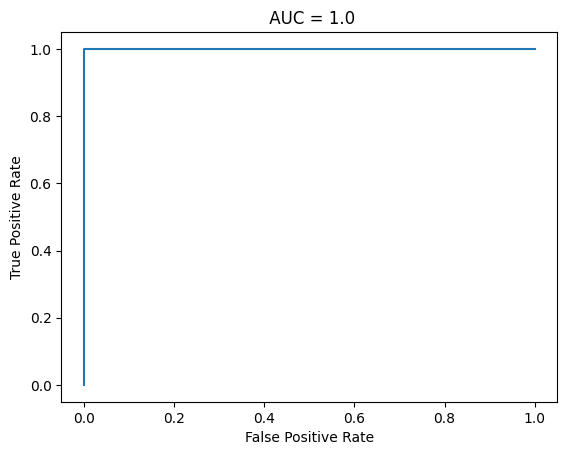

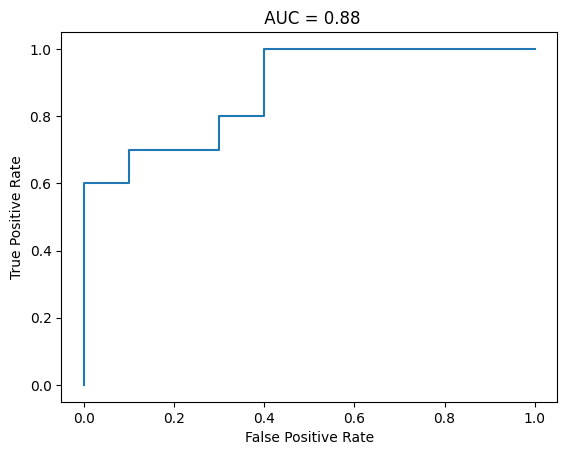

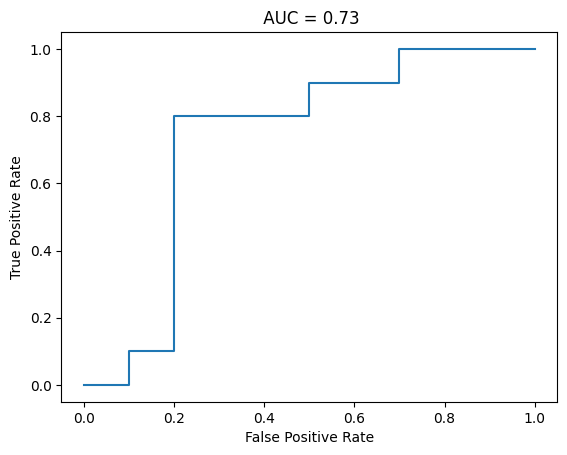

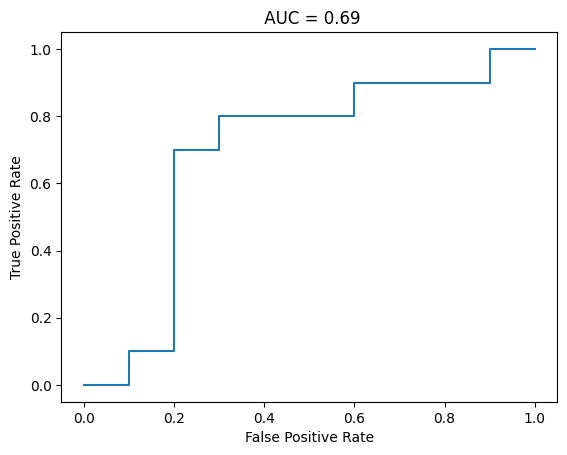

In [107]:
# calculo da auc da roc
roc = []
for index in range(0,4):
  roc.append(t3_fazroc(norm_adiposo[index,:], norm_cirrotico[index,:], nomecarac='', plotar=True))

Agora temos a auc e outros parâmetros retornados para cada uma das 4 caracteristicas

In [133]:
# acessando a auc da roc que servira como criterio
auc = np.asarray([roc[0][0], roc[1][0], roc[2][0], roc[3][0]])

# definindo os pesos
peso = [0.5, 0.5]

# calculo da correlacao
classes = np.concatenate((norm_adiposo, norm_cirrotico), axis=1)
corr = np.corrcoef(classes)

# selecao escalar de caracteristica
selected = t3_selescalar(corr, auc, peso)

print(selected)

[0, 3, 1, 2]


Pesos iguais (0.5, 0.5)

0.   média
1.   curtose
2.   desvio padrão
3.   obliquidade

Agora, faremos para o critério de Fisher - FDR

In [134]:
def t3_FDR(dado1,dado2):
    #Calcula o critério FDR entre duas matrizes caracteristicas x padroes
    #Inputs:
    # - dado1 = característica x padrões, classe 1
    # - dado2 = característica x padrões, classe 1
    #Outputs:
    # - fdr = valores de FDR para cada característica
    m1=np.mean(dado1,1)
    m2=np.mean(dado2,1)
    s1=np.var(dado1,axis=1,ddof=1)
    s2=np.var(dado2,axis=1,ddof=1)
    fdr=(m1-m2)**2/(s1+s2)
    return fdr

In [138]:
# calculo pelo criterio fdr
fdr = t3_FDR(norm_adiposo, norm_cirrotico)

# selecao escalar de caracteristica - pesos iguais
selected = t3_selescalar(corr, fdr, peso)

print(selected)

[0, 1, 2, 3]


Pesos iguais (0.5, 0.5)

0.   média
1.   desvio padrão
2.   obliquidade
3.   curtose


In [139]:
# selecao escalar de caracteristica - pesos distintos
peso_2 = [0.2, 0.8]
selected = t3_selescalar(corr, fdr, peso_2)

print(selected)

[0, 3, 1, 2]


Pesos diferentes (0.2, 0.8)

0.   media
1.   curtose
2.   desvio padrão
3.   obliquidade

# Seleção vetorial de características

No github do curso (main.py) você poderá encontrar o método “t3_selvetorial” que realiza a seleção vetorial exaustiva em um conjunto de características a partir das matrizes de espalhamento, calculadas no método “t3_matrizesdeespalhamento” (ver aula 07 para uma descrição do procedimento de seleção vetorial).

Novamente, garanta que você compreende o que está sendo realizado por estas funções e depois teste o procedimento de seleção vetorial nos dados do exercício anterior, selecionando duas características das quatro inicialmente presentes. Para este problema, não esqueça de normalizar antes os seus dados (uma normalização linear é suficiente, mas neste problema não é necessário realizar detecção de outliers ou pré-seleção). Gere alguns mapas bidimensionais e visualize a distinção entre as duas classes para diferentes valores dos critérios de seleção vetorial - por exemplo, o mapa contido na figura abaixo foi gerado com a seleção exaustiva após uma normalização linear

In [144]:
def t3_matrizesdeespalhamento(classes,selcars):
    #Calcula as matrizes de espalhamento a partir de uma lista de classes
    #Inputs:
    # - classes = lista em que cada elemento corresponde a um array características x padrões de cada classe
    # - selcars = índice de quais características usar no cálculo das matrizes
    #Outputs:
    # - matrizes de espalhamento: SW, SM e SB
    Ncl=len(classes)
    mean_vectors=[]
    for cl in range(Ncl):
        mean_vectors.append(np.mean(classes[cl][selcars,:],axis=1))
    prob=np.zeros(Ncl)
    N=0
    for i in range(Ncl):
        prob[i]=np.size(classes[i][selcars,:],axis=1)
        N=N+prob[i]
    prob=prob/N
    Ncar=len(selcars)
    SW=np.zeros((Ncar,Ncar))#within classes
    for cl in range(Ncl):
        varwithin=np.cov(classes[cl][selcars,:],ddof=0)
        SW=SW+prob[cl]*varwithin
    allclasses=classes[0][selcars,:]
    for cl in range(Ncl-1):
        allclasses=np.concatenate((allclasses,classes[cl+1][selcars,:]),axis=1)
    SM=np.cov(allclasses,ddof=0)
    SB = SM - SW
    return SW,SM,SB

In [ ]:
"""
como os dados já estão normalizados, então
podemos aplicar a função diretamente
"""

# unindo as classes em uma lista
classes = [norm_adiposo, norm_cirrotico]

# selecionando duas características das quatro presentes
features = [0, 1]

SW, SM, SB = t3_matrizesdeespalhamento(classes, features)

In [142]:
def t3_selvetorial(classes,n):
    #Calcula os critérios para seleção vetorial exaustiva de n características
    #Inputs:
    # - classes = lista em que cada elemento corresponde a um array características x padrões de cada classe
    # - n = número de características para selecionar
    #Outputs:
    # - J1, J2 e J3: critérios da seleção vetorial
    # - combs: lista com as características empregadas para cada valor de critério
    Ncar=np.size(classes[0],axis=0)
    combs=list(itertools.combinations(range(Ncar),n))
    J1=np.zeros(len(combs))
    J2=np.zeros(len(combs))
    J3=np.zeros(len(combs))
    for i in range(len(combs)): #todas combinacoes
        SW,SM,SB=t3_matrizesdeespalhamento(classes,combs[i])
        J1[i]=np.trace(SM)/np.trace(SW)
        J2[i]=np.linalg.det(SM)/np.linalg.det(SW)
        J3[i]=np.trace(np.dot(np.linalg.inv(SW),SM))/np.size(SW,axis=0)
    return J1, J2, J3, combs

NameError: ignored